# Introduction

Here I run the implementation of [cellphonedb](https://www.nature.com/articles/s41596-020-0292-x) from [squidpy](https://squidpy.readthedocs.io/en/stable/index.html). Because squidpy requires python > 3.8, I needed to create a separate environment to run it.

# Setup

In [1]:
import squidpy as sq
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import scipy
import pickle as pkl
import gc
import timeit
import networkx as nx
from nero import Nero as nr
from nero import utils as nrutils

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)
sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

scanpy==1.8.2 anndata==0.8.0 umap==0.5.2 numpy==1.21.5 scipy==1.8.0 pandas==1.4.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6
squidpy==1.1.2


In [3]:
mountpoint = '/data/clue/'
prefix_adts = mountpoint + 'prod/adts/'
prefix_mrna = mountpoint + 'prod/mrna/'
prefix_comb = mountpoint + 'prod/comb/'

In [4]:
with open(mountpoint + 'meta.pkl', 'rb') as file:
    cond_colors = pkl.load(file)['cond_colors']['hex']

# Load Data

In [5]:
path = prefix_comb + 'h5ads/concat_5.h5ad'
concat = sc.read_h5ad(path).raw.to_adata()

Going to be using ligand-receptor pairs from [Shao et al.](https://academic.oup.com/bib/article/22/4/bbaa269/5955941?login=true), which I procured through [this GitHub repository](https://github.com/LewisLabUCSD/Ligand-Receptor-Pairs) (and [accompanying paper](https://www.nature.com/articles/s41576-020-00292-x)):

```
wget https://raw.githubusercontent.com/LewisLabUCSD/Ligand-Receptor-Pairs/master/Human/Human-2020-Shao-LR-pairs.txt
```

In [6]:
lr_pairs_df = pd.read_csv(prefix_mrna + 'vals/Human-2020-Shao-LR-pairs.txt', sep='\t')
interactions = lr_pairs_df[['ligand_gene_symbol', 'receptor_gene_symbol']].rename(mapper=
                                                                                  {
                                                                                      'ligand_gene_symbol': 'source',
                                                                                      'receptor_gene_symbol': 'target'},
                                                                                  axis=1
                                                                                 )

You can use the following to check for any specific pair:

In [7]:
interactions[interactions.apply(lambda x: x.str.startswith('IL36')).any(1)]

,source,target
544,IL36G,IL36RN
545,IL36G,IL1RL2
549,IL36A,IL36RN
550,IL36A,IL1RL2
551,IL36B,IL36RN
552,IL36B,IL1RL2


In [188]:
interactions[interactions.apply(lambda x: x.str.startswith('SELL')).any(1)]

,source,target
282,SELPLG,SELL
1907,CALM2,SELL
1908,PODXL2,SELL
1909,VCAN,SELL
1910,CD34,SELL
1911,MUC7,SELL
1912,CALM1,SELL
1913,PODXL,SELL
1914,CALM3,SELL
1915,CFH,SELL


In [190]:
lr_pairs_df.loc[1912]

lr_pair                             CALM1_SELL
ligand_gene_symbol                       CALM1
receptor_gene_symbol                      SELL
ligand_gene_id                             801
receptor_gene_id                          6402
ligand_ensembl_protein_id      ENSP00000349467
receptor_ensembl_protein_id    ENSP00000236147
ligand_ensembl_gene_id         ENSG00000198668
receptor_ensembl_gene_id       ENSG00000188404
evidence                              21664913
Name: 1912, dtype: object

Because I want to explore the interesting cytotoxic T cells and NK cells, I'm going to regroup some of them to increase cell numbers.

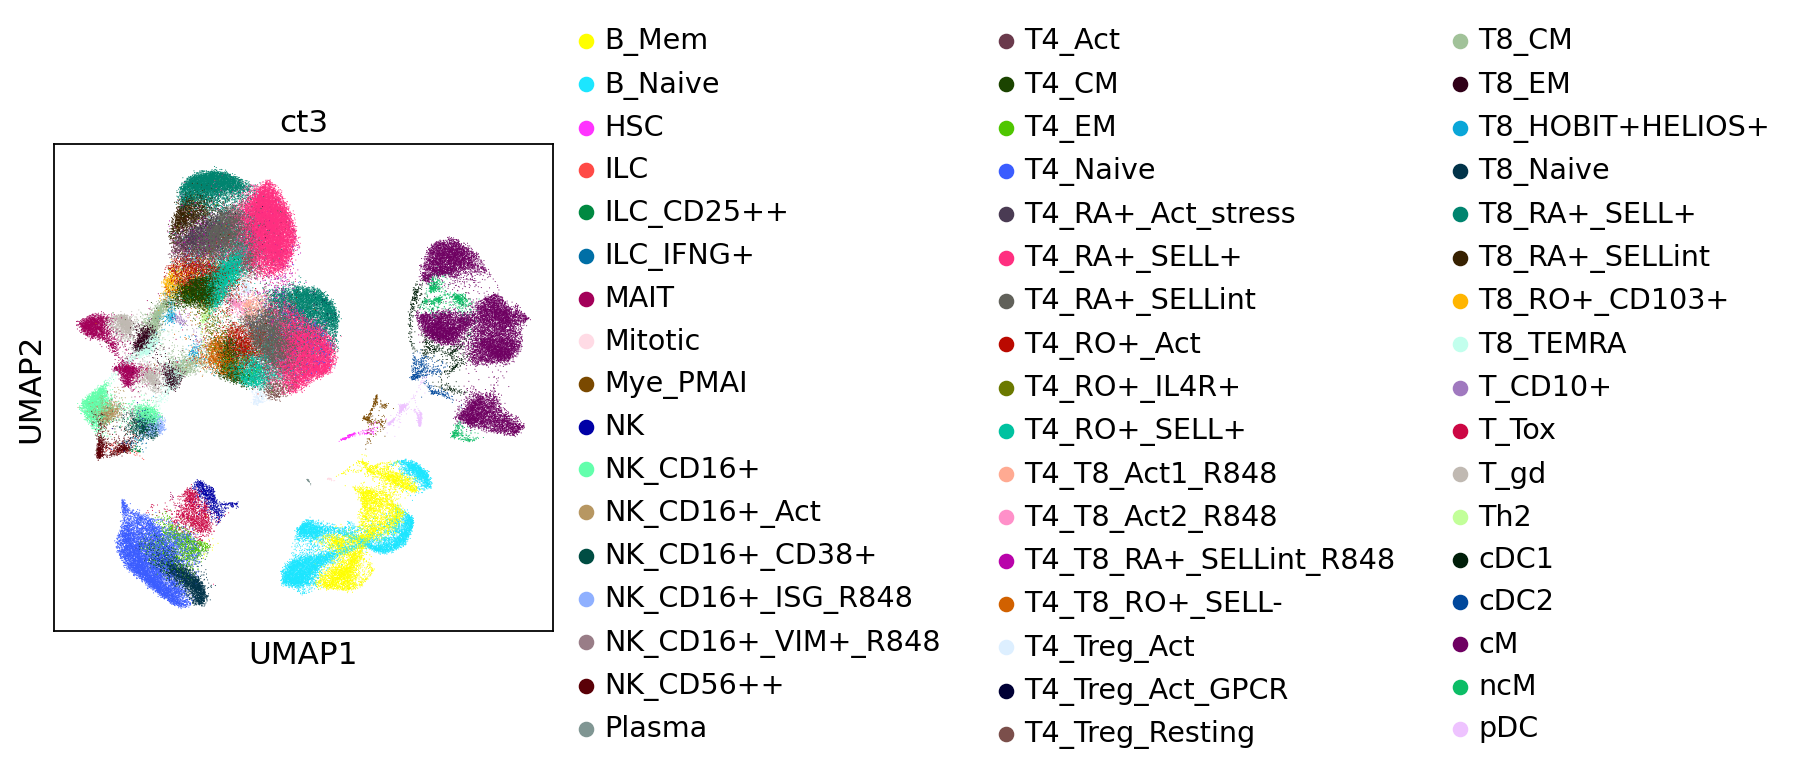

In [8]:
sc.pl.umap(concat, color='ct3')

In [83]:
nr.highlight_feature(concat, 'CD55')

In [61]:
ct3_copy = concat.obs['ct3'].astype(str).copy()
ct3_copy = ct3_copy.replace(r'NK_CD16\+_.*', 'NK_CD16+', regex=True)
concat.obs['ct5'] = ct3_copy.astype('category')

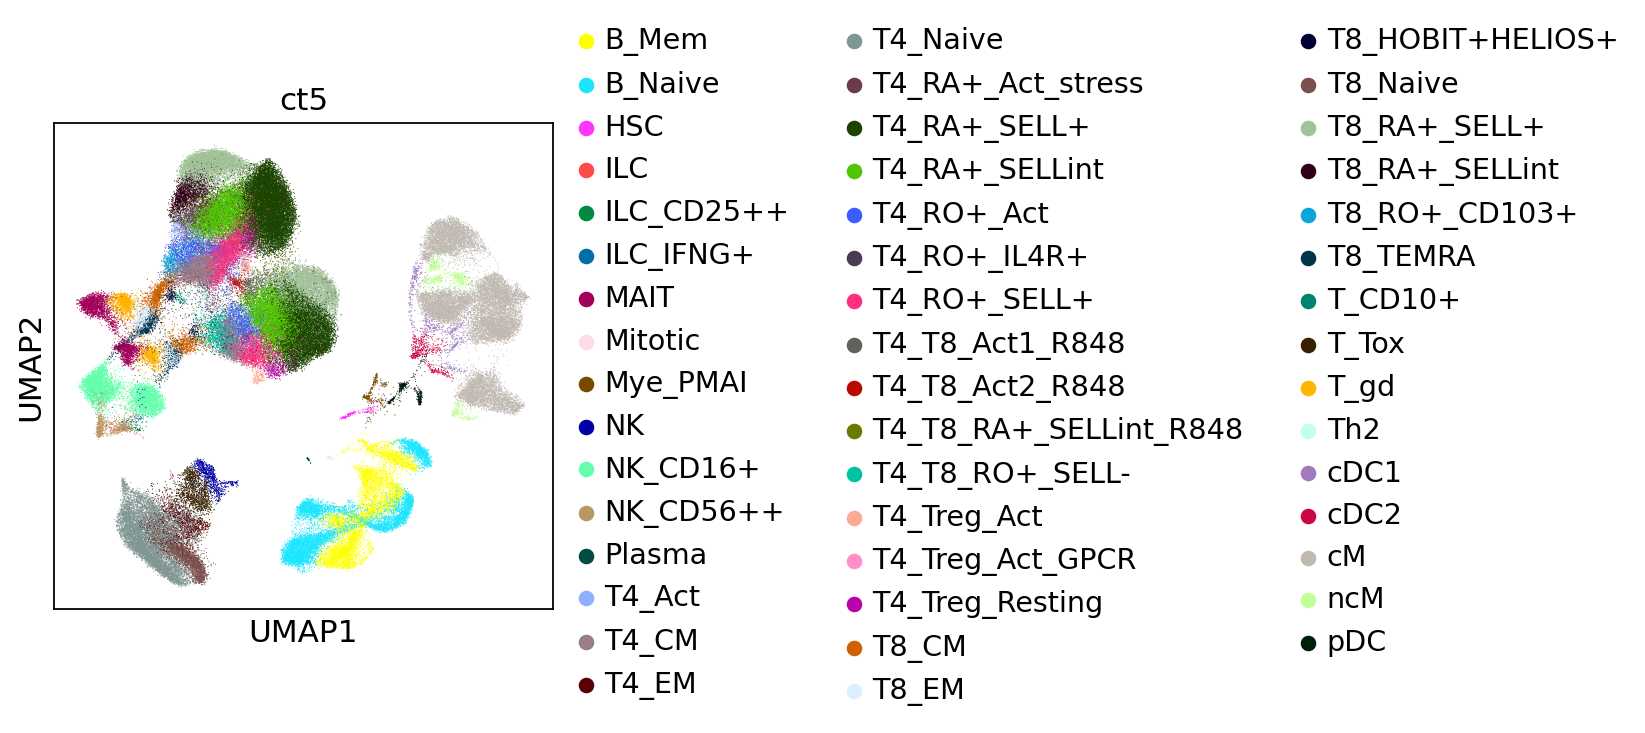

In [85]:
sc.pl.umap(concat, color='ct5')

In [62]:
conds = ['C', 'B', 'G']

In [63]:
for cond in conds:
    print(cond)
    print(concat.obs['ct5'][concat.obs['cond'] == cond].value_counts().loc[['MAIT', 'T_gd', 'T8_EM', 'T8_CM', 'T8_TEMRA', 'NK_CD56++', 'NK_CD16+']])
    print('')

C
MAIT          594
T_gd          393
T8_EM         289
T8_CM         359
T8_TEMRA      240
NK_CD56++     196
NK_CD16+     1078
Name: ct5, dtype: int64

B
MAIT          590
T_gd          402
T8_EM         345
T8_CM         367
T8_TEMRA      260
NK_CD56++     223
NK_CD16+     1157
Name: ct5, dtype: int64

G
MAIT         566
T_gd         436
T8_EM        328
T8_CM        357
T8_TEMRA     258
NK_CD56++    185
NK_CD16+     938
Name: ct5, dtype: int64



# Run `sq.ligrec()`

In [64]:
ligrec = dict()

In [102]:
ct_pairs = [
    ['MAIT', 'cM'],
    ['B_Mem', 'cM'],
    ['NK_CD16+', 'cM']
]
keys = dict(zip(['-'.join(pair) for pair in ct_pairs], ct_pairs))

In [87]:
for key in keys:
    ligrec[key] = dict()
    for cond in tqdm(conds):
        sub_adata = dict()
        adata = concat[(concat.obs['ct5'].isin(keys[key]) & (concat.obs['cond'] == cond))].copy()
        ligrec[key][cond] = sq.gr.ligrec(
            adata,
            interactions=interactions,
            use_raw=False,
            n_perms=100,
            cluster_key="ct5",
            n_jobs=12, 
            threshold=0.1,
            copy=True
        )

  0%|          | 0/3 [00:00<?, ?it/s]

    DEBUG: Removing duplicate interactions
    DEBUG: Removing duplicate genes in the data
    DEBUG: Selecting genes from complexes based on minimum average expression
    DEBUG: Removing interactions with no genes in the data
    DEBUG: Removing genes not in any interaction
Running `100` permutations on `1872` interactions and `4` cluster combinations using `12` core(s)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Finish (0:00:12)
    DEBUG: Removing duplicate interactions
    DEBUG: Removing duplicate genes in the data
    DEBUG: Selecting genes from complexes based on minimum average expression
    DEBUG: Removing interactions with no genes in the data
    DEBUG: Removing genes not in any interaction
Running `100` permutations on `1872` interactions and `4` cluster combinations using `12` core(s)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Finish (0:00:02)
    DEBUG: Removing duplicate interactions
    DEBUG: Removing duplicate genes in the data
    DEBUG: Selecting genes from complexes based on minimum average expression
    DEBUG: Removing interactions with no genes in the data
    DEBUG: Removing genes not in any interaction
Running `100` permutations on `1872` interactions and `4` cluster combinations using `12` core(s)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Finish (0:00:03)


  0%|          | 0/3 [00:00<?, ?it/s]

    DEBUG: Removing duplicate interactions
    DEBUG: Removing duplicate genes in the data
    DEBUG: Selecting genes from complexes based on minimum average expression
    DEBUG: Removing interactions with no genes in the data
    DEBUG: Removing genes not in any interaction
Running `100` permutations on `1872` interactions and `4` cluster combinations using `12` core(s)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Finish (0:00:03)
    DEBUG: Removing duplicate interactions
    DEBUG: Removing duplicate genes in the data
    DEBUG: Selecting genes from complexes based on minimum average expression
    DEBUG: Removing interactions with no genes in the data
    DEBUG: Removing genes not in any interaction
Running `100` permutations on `1872` interactions and `4` cluster combinations using `12` core(s)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Finish (0:00:03)
    DEBUG: Removing duplicate interactions
    DEBUG: Removing duplicate genes in the data
    DEBUG: Selecting genes from complexes based on minimum average expression
    DEBUG: Removing interactions with no genes in the data
    DEBUG: Removing genes not in any interaction
Running `100` permutations on `1872` interactions and `4` cluster combinations using `12` core(s)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Finish (0:00:02)


  0%|          | 0/3 [00:00<?, ?it/s]

    DEBUG: Removing duplicate interactions
    DEBUG: Removing duplicate genes in the data
    DEBUG: Selecting genes from complexes based on minimum average expression
    DEBUG: Removing interactions with no genes in the data
    DEBUG: Removing genes not in any interaction
Running `100` permutations on `1872` interactions and `4` cluster combinations using `12` core(s)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Finish (0:00:02)
    DEBUG: Removing duplicate interactions
    DEBUG: Removing duplicate genes in the data
    DEBUG: Selecting genes from complexes based on minimum average expression
    DEBUG: Removing interactions with no genes in the data
    DEBUG: Removing genes not in any interaction
Running `100` permutations on `1872` interactions and `4` cluster combinations using `12` core(s)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Finish (0:00:03)
    DEBUG: Removing duplicate interactions
    DEBUG: Removing duplicate genes in the data
    DEBUG: Selecting genes from complexes based on minimum average expression
    DEBUG: Removing interactions with no genes in the data
    DEBUG: Removing genes not in any interaction
Running `100` permutations on `1872` interactions and `4` cluster combinations using `12` core(s)


  0%|          | 0/100 [00:00<?, ?permutation/s]

Finish (0:00:03)


In [93]:
# with open(prefix_mrna + 'pkls/ligrec_all_ShaoLR.pkl', 'wb') as file:
#     pkl.dump(ligrec, file)
with open(prefix_mrna + '/pkls/ligrec_all_ShaoLR.pkl', 'rb') as file:
    ligrec = pkl.load(file)

In [177]:
ligrec.keys()

dict_keys(['MAIT-cM', 'B_Mem-cM', 'NK_CD16+-cM'])

# Plot

Make a dictionary to store the log2FC of changed receptor-ligand pair expression.

In [178]:
l2fc_melt_dict = dict()
for key in keys:
    cts = keys[key]
    interax_key = tuple(cts[::-1]) # flip it so cM are source and other cell type is target
    ligrec_sig = pd.concat([ligrec[key][cond]['means'][interax_key][ligrec[key][cond]['pvalues'][interax_key] < 0.05] for cond in conds], axis=1, keys=conds)
    l2fcs = list()
    for cond in ['G', 'B']:
        sub_ligrec = ligrec_sig[(ligrec_sig[cond] > 0) & (ligrec_sig['C'] > 0)]
        l2fcs.append(np.log2(sub_ligrec[cond]/sub_ligrec['C']).rename('l2fc'))
    l2fc = pd.concat(l2fcs, axis=1, keys=['G', 'B'])
    l2fc_melt = pd.concat([l2fc['G'][l2fc['G'].abs() > 0.5], l2fc['B'][l2fc['B'].abs() > 0.5]], axis=1, keys=['G', 'B']).reset_index().melt(id_vars=['source', 'target'], var_name='cond', value_name='means')
    keydict = dict(zip(*np.unique(l2fc_melt[['source', 'target']].values.flatten(), return_counts=True)))
    l2fc_melt_dict[key] = l2fc_melt.sort_values(by=['source', 'target'], key=lambda x: x.map(keydict), ascending=False)

In [179]:
def interax_graph(l2fc_melt, factor=1, sort_targets=True, plot_hist=False,
                  figsize=(4.5, 10), sbuffer=0.15, tbuffer=0, fontsize=10, cmap='bwr'):
    
    # sort the targets
    if sort_targets:
        l2fc_melt = l2fc_melt.sort_values(by=['target', 'source'], ascending=False).reset_index(drop=True)
    
    # create dictionaries mapping items to locations on the plot
    ## source
    s_uniq_gn = l2fc_melt['source'].unique()
    
    if not sort_targets:
        np.random.seed(0)
        s_uniq_gn = np.random.choice(s_uniq_gn, size=len(s_uniq_gn), replace=False)

    s_dict = dict([(gn, i*factor) for (i , gn) in enumerate(s_uniq_gn)])
    s_dict_inv = dict([(v, k) for k, v in s_dict.items()])

    ## target
    t_uniq_gn = l2fc_melt['target'].unique()
    
    if not sort_targets:
        np.random.seed(0)
        t_uniq_gn = np.random.choice(t_uniq_gn, size=len(t_uniq_gn), replace=False)

    t_dict = dict([(gn, i) for (i , gn) in enumerate(t_uniq_gn)])
    t_dict_inv = dict([(v, k) for k, v in t_dict.items()])
    
    # create the df to store all the graph information
    
    df_plot = l2fc_melt.copy()
    df_plot['source'] = df_plot['source'].map(s_dict)
    df_plot['target'] = df_plot['target'].map(t_dict)
    
    # shift the sources to vertically center them
    shift = df_plot['target'].max()/2 - df_plot['source'].max()/2
    df_plot['source'] += shift

    # get unique sources and targets
    uniq_s = df_plot['source'].unique()
    uniq_t = df_plot['target'].unique()
    
    # get the conditions we're plotting, inferred
    conds = l2fc_melt['cond'].unique()
    
    # plot a histogram to show the log2FC's for all significant interactions
    if plot_hist:
        plt.figure(figsize=(5, 3))
        plt.hist(df_plot[df_plot['cond'] == 'G'][['means']].dropna(), bins=np.linspace(-2, 2, 20), facecolor=cond_colors['G'], alpha=0.5)
        plt.hist(df_plot[df_plot['cond'] == 'B'][['means']].dropna(), bins=np.linspace(-2, 2, 20), facecolor=cond_colors['B'], alpha=0.5);
        plt.show()
        
    cmap = plt.get_cmap(cmap)
    
    # add a buffer to the x values
    xs = [(1 - sbuffer, sbuffer), (1 + sbuffer, 2 - sbuffer)]
    
    # color and width of the lines will be determined by the weight, need to normalize for color though
    df_plot['weight'] = nrutils.norm_between(np.clip(df_plot['means'].fillna(0).values, -2, 2), 0, 1)
    df_plot['weight_abs'] = nrutils.norm_between(np.abs(np.clip(df_plot['means'].fillna(0).values, -2, 2)), 0, 1)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize, sharey=True)

    for cond, x in zip(focus_conds, xs):
        df_plot_cond = df_plot[df_plot['cond'] == cond].copy()
        for idx, row in df_plot_cond.iterrows():
            ax.plot(x, [row['source'], row['target']], 
                    c=bwr(row['weight']), 
                    linewidth=abs(row['means']), 
                    solid_capstyle='round')
    ax.grid()
    
    # add the labels
    for s in uniq_s:
        ax.text(1, s, s_dict_inv[s - shift], fontdict={'size': fontsize}, ha='center', va='center')
    

    for t in uniq_t: # add a little extra buffer if necessary
        ax.text(sbuffer - tbuffer, t, t_dict_inv[t], fontdict={'size': fontsize}, ha='right', va='center')
        ax.text(2 - sbuffer + tbuffer, t, t_dict_inv[t], fontdict={'size': fontsize}, ha='left', va='center')
    
    plt.axis('off');
    plt.show()
    

## cM → MAIT

In [180]:
key = 'MAIT-cM'
l2fc_melt = l2fc_melt_dict[key]

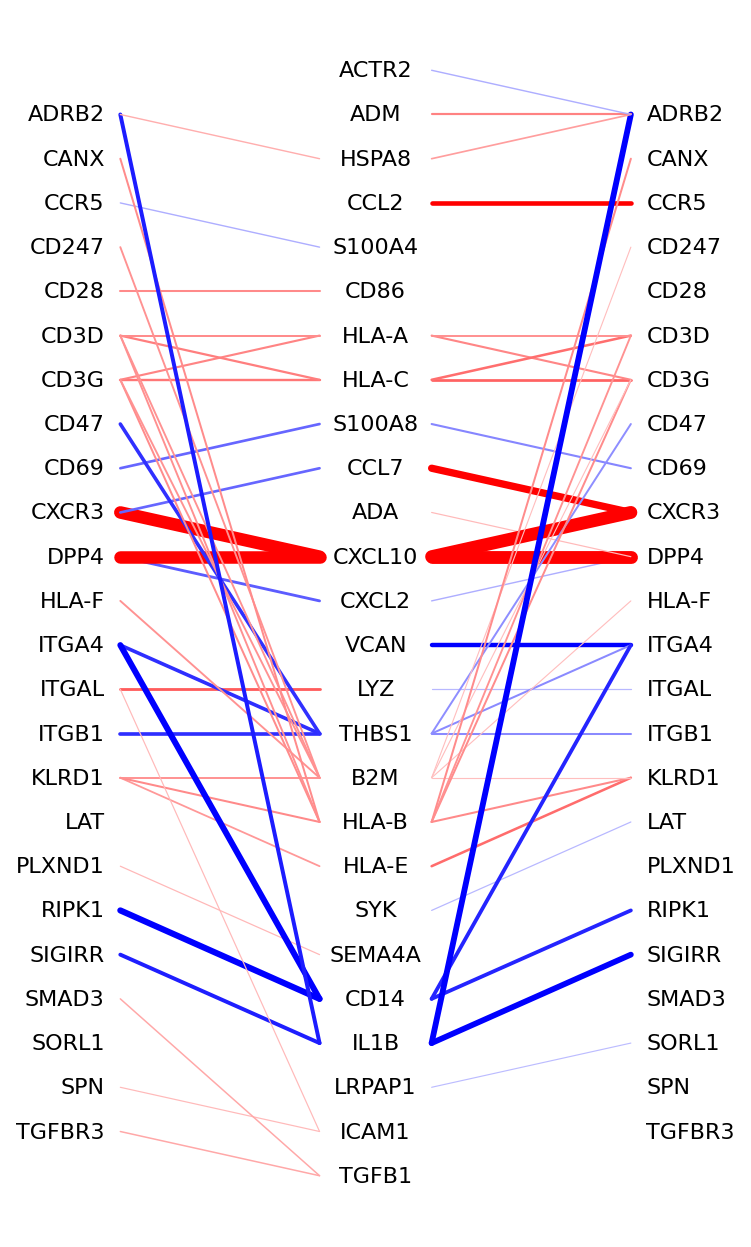

In [181]:
interax_graph(l2fc_melt, sbuffer=0.18, tbuffer=0.05)

## cM → NK_CD16+

In [182]:
key = 'NK_CD16+-cM'
l2fc_melt = l2fc_melt_dict[key]

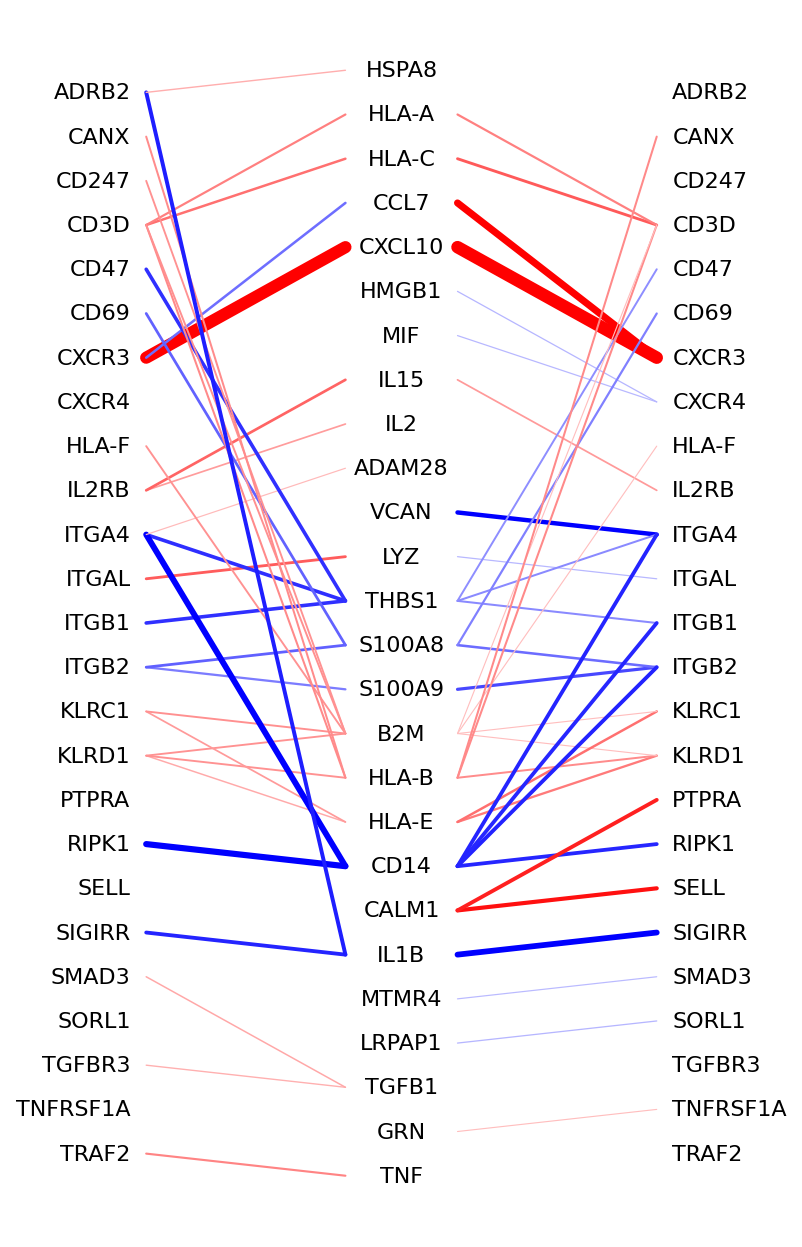

In [183]:
interax_graph(l2fc_melt, sbuffer=0.18, tbuffer=0.05)

## cM → B_Mem

In [184]:
key = 'B_Mem-cM'
l2fc_melt = l2fc_melt_dict[key]

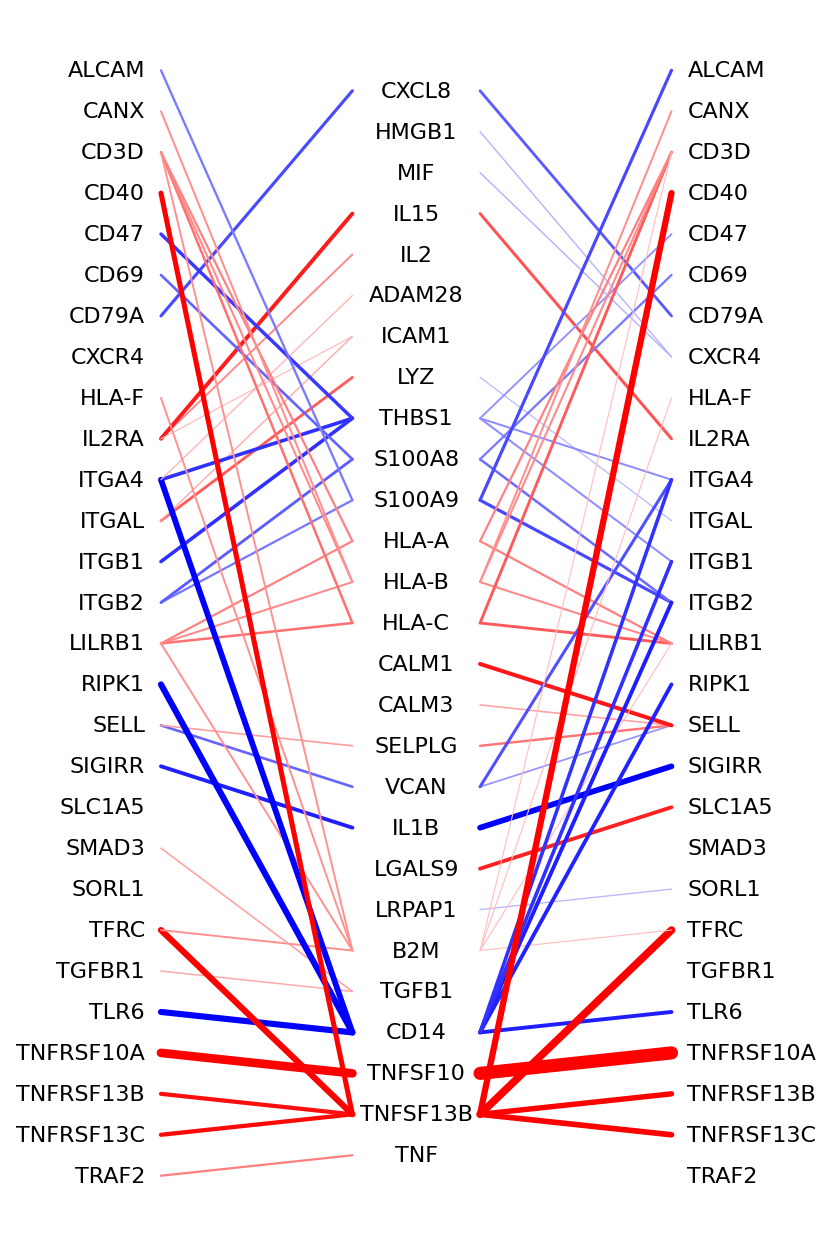

In [186]:
interax_graph(l2fc_melt, sbuffer=0.2, tbuffer=0.05)